# Abstract

This notebook reproduces the Langevian sampling on celeba dataset

Source of pretrained GAN: https://github.com/joeylitalien/celeba-gan-pytorch/tree/master

In [19]:
import os
import imageio

import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.parallel
from torch.distributions import MultivariateNormal, Normal, Independent, Uniform

import torchvision

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sys
sys.path.append('...')

from celeba_data.generator_class import Generator, Discriminator

In [3]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

# Models

In [4]:
model_gen = Generator()
model_gen.load_state_dict(torch.load('celeba_data/gan-gen.pt', map_location=device))
model_gen.to(device).eval()

model_disc = Discriminator()
model_disc.load_state_dict(torch.load('celeba_data/gan-disc.pt', map_location=device))
model_disc.to(device).eval()

Discriminator(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
    (12): Sigmoid()
  )
)

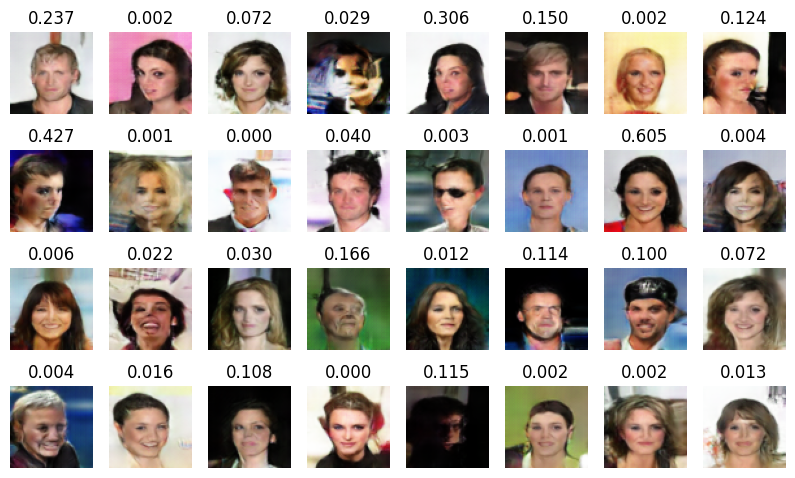

In [5]:
batch_size=32
n_dims = 100

plt.figure(figsize=[10,12])
noize=torch.randn(batch_size, n_dims)

samples=model_gen(noize.to(device))
samples=samples*0.5+0.5
score=model_disc(model_gen(noize.to(device)))

for i in range(batch_size):
    plt.subplot(8,8,i+1)
    plt.axis('off')
    plt.title(f"{score[i].cpu().detach().numpy():.3f}")
    plt.imshow(samples[i].permute(1,2,0).cpu().detach().numpy())

# FID
Now compute Frechet Inception distance - a metric for GANs

In [6]:
from torcheval.metrics import FrechetInceptionDistance
import torchvision.transforms as transforms


transform = transforms.Compose(
    [transforms.ToTensor()]) 

trainset = torchvision.datasets.CIFAR10(root='./cifar10_data/data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)

real = next(iter(trainloader))[0]
fake = samples.to('cpu')

fid = FrechetInceptionDistance()

fid.update(real, True)
fid.update(fake, False)
fid.compute()

Files already downloaded and verified


tensor(322.2054)

# Energy sampling

In [7]:
def langevin_sampling(N, z_dim, generator, discriminator, device, eps=1e-3, save_arr = False):
    eps = torch.tensor([eps]).to(device)
    # Create normal distribution
    loc = torch.zeros(z_dim).to(device)
    scale = torch.ones(z_dim).to(device)
    normal = Normal(loc, scale)
    # Making it independent
    diagn = Independent(normal, 1)
    # init noise
    z = diagn.sample()
    # save noise if needed
    if save_arr:
        noise_arr = []
        noise_arr.append(z.view(1, z.size()[0]))
    # Begin iterations
    for i in range(N):
        z.requires_grad = True
        n = normal.sample()
        # compute energy function
        log_p = diagn.log_prob(z)
        d = discriminator(generator(z.view(1, z.size()[0])))
        energy = -log_p - d
        # gradient
        energy.backward()
        # get new point
        with torch.no_grad():
            z = z - eps / 2 * z.grad + torch.sqrt(eps) * n
        if save_arr:
            noise_arr.append(z.view(1, z.size()[0]))
            
    if save_arr:
        return z, noise_arr
    else:
        return z

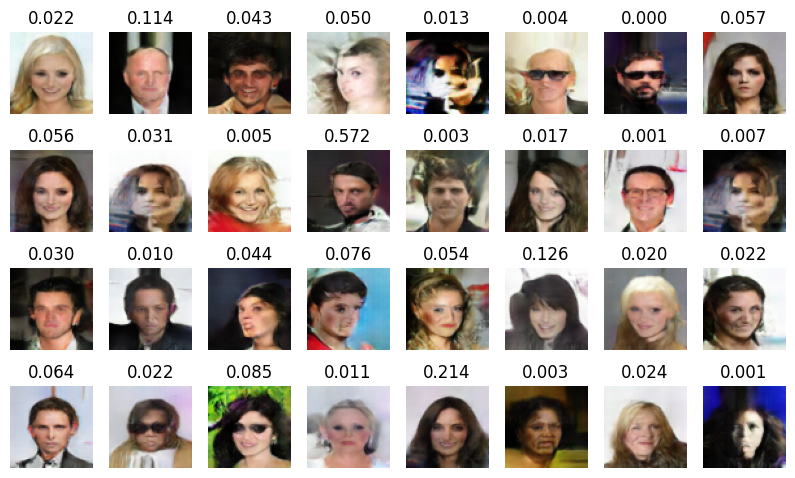

In [8]:
batch_size=32
n_dims = 100

N = 10
eps=1e-3

plt.figure(figsize=[10,12])

noize=[]
for i in range(batch_size):
    noize.append(langevin_sampling(N, n_dims, model_gen, model_disc, device, eps=eps).to('cpu'))
noize = torch.tensor(np.array(noize))

samples=model_gen(noize.to(device))
samples=samples*0.5+0.5
score=model_disc(model_gen(noize.to(device)))

for i in range(batch_size):
    plt.subplot(8,8,i+1)
    plt.axis('off')
    plt.title(f"{score[i].cpu().detach().numpy():.3f}")
    plt.imshow(samples[i].permute(1,2,0).cpu().detach().numpy())

In [9]:
real = next(iter(trainloader))[0]
fake = samples.to('cpu')

fid = FrechetInceptionDistance()

fid.update(real, True)
fid.update(fake, False)
fid.compute()

tensor(317.3144)

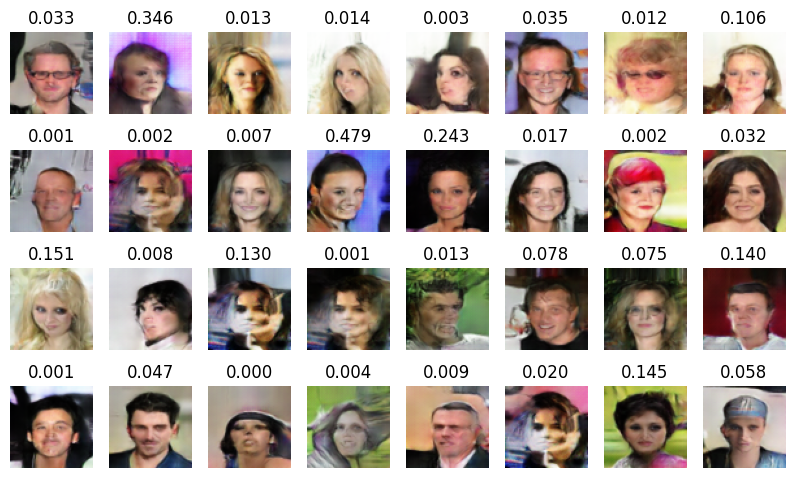

In [10]:
batch_size=32
n_dims = 100

N = 10
eps=1e-5

plt.figure(figsize=[10,12])

noize=[]
for i in range(batch_size):
    noize.append(langevin_sampling(N, n_dims, model_gen, model_disc, device, eps=eps).to('cpu'))
noize = torch.tensor(np.array(noize))

samples=model_gen(noize.to(device))
samples=samples*0.5+0.5
score=model_disc(model_gen(noize.to(device)))

for i in range(batch_size):
    plt.subplot(8,8,i+1)
    plt.axis('off')
    plt.title(f"{score[i].cpu().detach().numpy():.3f}")
    plt.imshow(samples[i].permute(1,2,0).cpu().detach().numpy())

In [11]:
real = next(iter(trainloader))[0]
fake = samples.to('cpu')

fid = FrechetInceptionDistance()

fid.update(real, True)
fid.update(fake, False)
fid.compute()

tensor(297.3889)

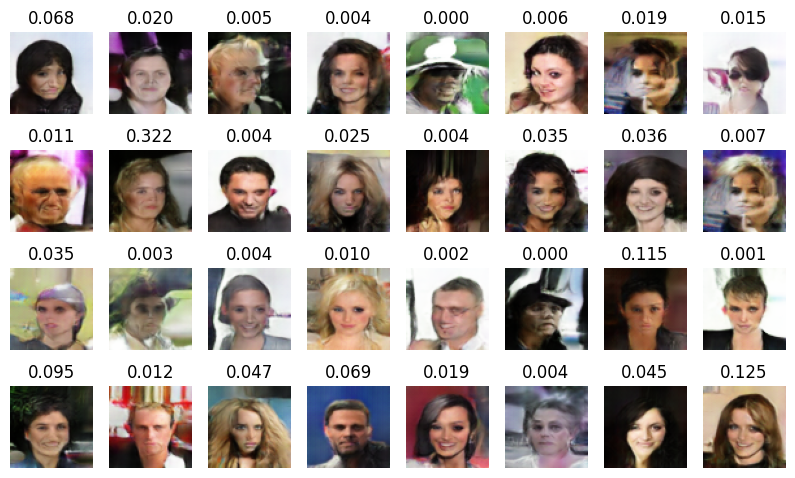

In [12]:
batch_size=32
n_dims = 100

N = 10
eps=1e-7

plt.figure(figsize=[10,12])

noize=[]
for i in range(batch_size):
    noize.append(langevin_sampling(N, n_dims, model_gen, model_disc, device, eps=eps).to('cpu'))
noize = torch.tensor(np.array(noize))

samples=model_gen(noize.to(device))
samples=samples*0.5+0.5
score=model_disc(model_gen(noize.to(device)))

for i in range(batch_size):
    plt.subplot(8,8,i+1)
    plt.axis('off')
    plt.title(f"{score[i].cpu().detach().numpy():.3f}")
    plt.imshow(samples[i].permute(1,2,0).cpu().detach().numpy()) # 00:43<00:00,  1.35s/it

In [13]:
real = next(iter(trainloader))[0]
fake = samples.to('cpu')

fid = FrechetInceptionDistance()

fid.update(real, True)
fid.update(fake, False)
fid.compute()

tensor(313.9386)

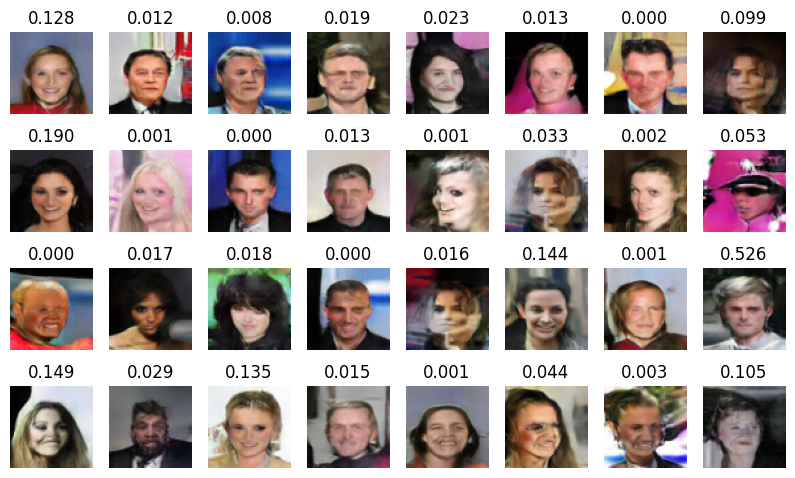

In [14]:
batch_size=32
n_dims = 100

N = 10
eps=1e-7

plt.figure(figsize=[10,12])

noize=[]
for i in range(batch_size):
    noize.append(langevin_sampling(N, n_dims, model_gen, model_disc, device, eps=eps).to('cpu'))
noize = torch.tensor(np.array(noize))

samples=model_gen(noize.to(device))
samples=samples*0.5+0.5
score=model_disc(model_gen(noize.to(device)))

for i in range(batch_size):
    plt.subplot(8,8,i+1)
    plt.axis('off')
    plt.title(f"{score[i].cpu().detach().numpy():.3f}")
    plt.imshow(samples[i].permute(1,2,0).cpu().detach().numpy()) # 00:43<00:00,  1.35s/it

In [15]:
real = next(iter(trainloader))[0]
fake = samples.to('cpu')

fid = FrechetInceptionDistance()

fid.update(real, True)
fid.update(fake, False)
fid.compute()

tensor(313.5452)

# Alternative computation

! working


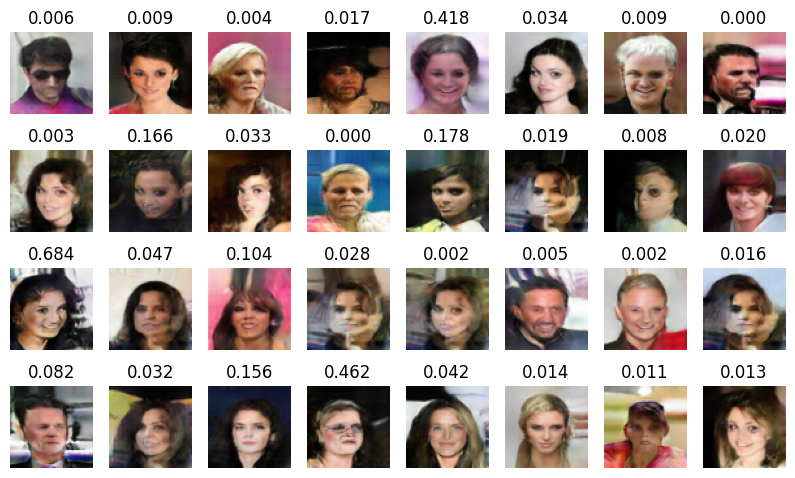

In [16]:
def Score_greadient(z, gen, disc):
    z_new=z.clone().requires_grad_(True)
    score_z_new=disc(gen(z_new.to(device)))
    gradients = torch.autograd.grad(outputs=score_z_new, 
                                    inputs=z_new,
                                    grad_outputs=torch.ones_like(score_z_new),
                                    create_graph=False, 
                                    retain_graph=False, 
                                    only_inputs=True)[0]
    return gradients.detach()
 

lr_grad=1e-7
noize=torch.randn(32, 100)
z_noize=noize.clone()
#vary learning 1e-5, 1e-6, 1e-7
for i in range(20):
    z_noize=z_noize+0.5*lr_grad*Score_greadient(z_noize, model_gen, model_disc)+torch.randn_like(z_noize)*np.sqrt(lr_grad)
print('! working')


plt.figure(figsize=[10,12])
samples=model_gen(z_noize.to(device))
samples=samples*0.5+0.5
score=model_disc(model_gen(z_noize.to(device)))

for i in range(batch_size):
    plt.subplot(8,8,i+1)
    plt.axis('off')
    plt.title(f"{score[i].cpu().detach().numpy():.3f}")
    plt.imshow(samples[i].permute(1,2,0).cpu().detach().numpy())

In [17]:
real = next(iter(trainloader))[0]
fake = samples.to('cpu')

fid = FrechetInceptionDistance()

fid.update(real, True)
fid.update(fake, False)
fid.compute()

tensor(304.1725)

# Animation

  0%|                                                   | 0/151 [00:00<?, ?it/s]/var/folders/b0/txks7w3n6d5bnxbphmt_jq0w0000gn/T/ipykernel_27843/2729315647.py:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_list.append(imageio.imread('Image_gen_langevin.png'))
100%|█████████████████████████████████████████| 151/151 [01:42<00:00,  1.47it/s]


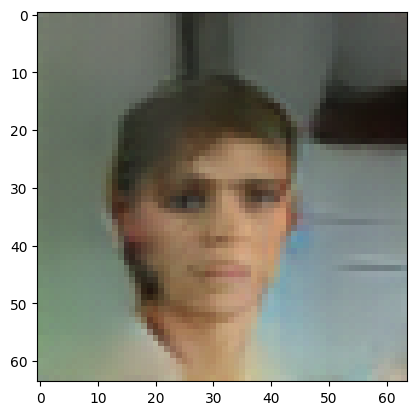

In [18]:
N = 150
eps = 1e-4
images_list=[]

_, noize_arr = langevin_sampling(N, n_dims, model_gen, model_disc, device, eps=eps, save_arr=True)

for noize in tqdm(noize_arr):
    samples_gen=model_gen(noize)
    samples_gen=samples_gen*0.5+0.5
    
    plt.imshow(samples_gen.squeeze().permute(1,2,0).cpu().detach().numpy())
    plt.savefig('./images/Image_gen_langevin.png')
    
    images_list.append(imageio.imread('./images/Image_gen_langevin.png'))
    imageio.mimsave('./images/celeba_langevin_gen.gif',images_list)

  0%|                                                   | 0/150 [00:00<?, ?it/s]/var/folders/b0/txks7w3n6d5bnxbphmt_jq0w0000gn/T/ipykernel_27944/821519464.py:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_list.append(imageio.imread('Image_gen_langevin.png'))
100%|█████████████████████████████████████████| 150/150 [01:47<00:00,  1.39it/s]


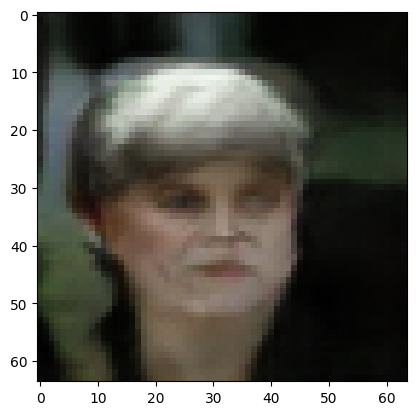

In [20]:
images_list=[]
noize=torch.randn(32, 100)
z_noize=noize.clone()
lr_grad=1e-4

#vary learning 1e-5, 1e-6, 1e-7
for i in tqdm(range(150)):
    z_noize=z_noize+0.5*lr_grad*Score_greadient(z_noize, model_gen, model_disc)+torch.randn_like(z_noize)*np.sqrt(lr_grad)
    samples_gen=model_gen(z_noize.to(device))
    samples_gen=samples_gen*0.5+0.5
    plt.imshow(samples_gen[-1].permute(1,2,0).cpu().detach().numpy())
    plt.savefig('./images/Image_gen_langevin.png')
    images_list.append(imageio.imread('./images/Image_gen_langevin.png'))
    imageio.mimsave('./images/celeba_alternative_langevin.gif',images_list)